In [2]:
import trimesh
import trimesh.transformations as TF
import numpy as np
import imageio
assert(trimesh.ray.has_embree)
import PIL.Image
import tqdm
import cv2


In [ ]:
import torch


In [3]:
bunny = trimesh.load("/home/jiahui/DR/tsdf-fusion-python/mesh.ply")
bunny.bounding_box.bounds

array([[-0.298976  , -0.61793399, -0.260032  ],
       [ 0.29935101,  0.50233698,  0.25996801]])

In [3]:
res=1024

def render_mask(vertices, mesh, origin, ray_dir):
    ind_tri = mesh.ray.intersects_first(origin, ray_dir)
    hitted = (ind_tri != -1)
    return hitted


In [4]:
target_mesh = trimesh.load("/root/mnt/DR/data/hand.ply")
target_mesh.apply_transform(TF.rotation_matrix(-np.pi/2, [1,0,0]))
vertices = target_mesh.vertices

scene = target_mesh.scene()

Masks = []
Rs = []
Ks = []
for i in tqdm.trange(0,360,2):
    angle = TF.euler_from_matrix(TF.rotation_matrix(np.pi/180*i, [0,1,0]))
    scene.set_camera(resolution=(res,res), fov=(60,60), angles=angle)
    Rs.append(scene.camera_transform)
    Ks.append(scene.camera.K)
    origin, ray_dir, _ = scene.camera_rays()
    origin = origin
    ray_dir = ray_dir
    mask = np.zeros(ray_dir.shape[0],dtype=np.uint8)
    index = render_mask(vertices, target_mesh, origin, ray_dir)
    mask[index] = 1
    mask = mask.reshape(res,res)[::-1]
    Masks.append(np.swapaxes(mask,0,1))

100%|██████████| 180/180 [00:33<00:00,  5.31it/s]


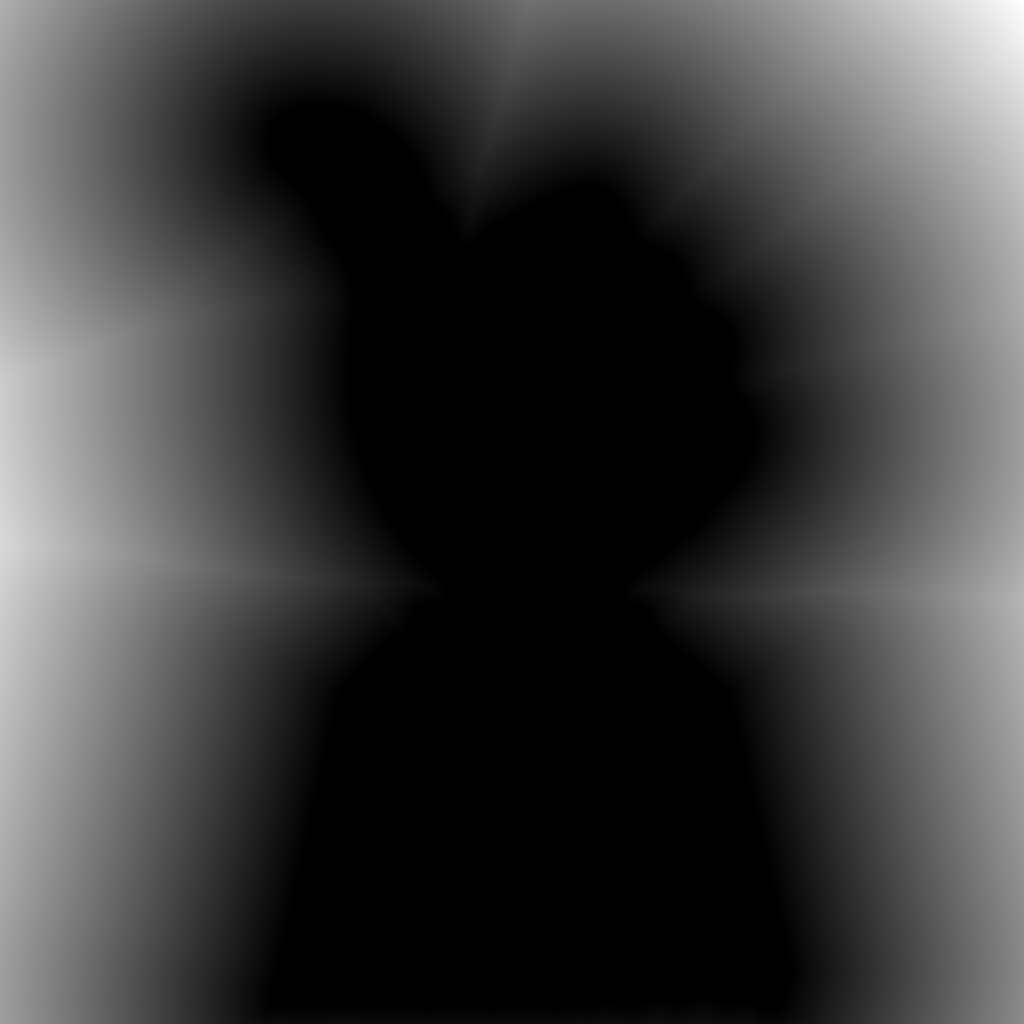

In [5]:
dist = cv2.distanceTransform(1-Masks[0], cv2.DIST_L2, 0)
img=dist
# img[img>1]=0
image = 255 * (img-img.min()) / (img.max()-img.min())
PIL.Image.fromarray(np.uint8(image))


In [45]:
dist.max()

103.17461

In [6]:
Ks = np.array(Ks)
Rs = np.array(Rs)
Masks = np.array(Masks)

In [7]:
np.savez("K_R_M",Ks,Rs,Masks)